In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm

use_cuda = torch.cuda.is_available()
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")


Matplotlib is building the font cache; this may take a moment.
c:\Users\Louis\miniconda3\envs\nfl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


__CUDNN VERSION: 8500
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA GeForce RTX 3060 Ti
__CUDA Device Total Memory [GB]: 8.589279232


In [339]:
data = pd.read_csv('merged_data')
data.replace([np.inf, -np.inf,np.nan], 0, inplace=True)
X = data.drop(['season','Unnamed: 0','f_points','u_points','favorite','underdog',
'spread_win','spread_tie','spread_loss','ou_over','ou_tie','ou_under'],axis=1)
y = data['f_points']+data['u_points']
X_train, X_valid, y_train, y_valid = train_test_split( X, y, test_size=0.4,shuffle=False)
X_valid, X_test, y_valid, y_test = train_test_split( X_valid, y_valid, test_size=0.5,shuffle=False)

In [340]:
from numpy import dtype

x_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()

x_train_torch = torch.from_numpy(x_train_np).float()
y_train_torch = torch.from_numpy(y_train_np).float()
x_train_torch = x_train_torch.to(device)
y_train_torch = y_train_torch.to(device)

In [351]:
# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. The Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
# The Flatten layer flatens the output of the linear layer to a 1D tensor,
# to match the shape of `y`.
model = torch.nn.Sequential(
    torch.nn.Linear(77, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 5),
    torch.nn.ReLU(),
    torch.nn.Linear(5, 1),
    torch.nn.Flatten(0, 1)
)
model.to(device)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.L1Loss(reduction='sum')

learning_rate = 1e-7
for t in range(5000):

    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(x_train_torch)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y_train_torch)
    if t % 1000 == 99:
        print(t, loss.item())

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

99 19355.912109375
1099 19259.482421875
2099 19236.67578125
3099 19221.45703125
4099 19207.533203125


614it [00:00, 1516.28it/s]


Accuracy:  0.0
10.830742919872172


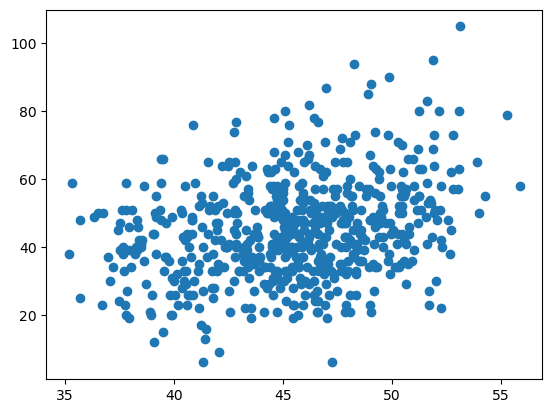

In [352]:
import math
from matplotlib import pyplot as plt
from sklearn import metrics

x_valid_np = X_valid.to_numpy()
y_valid_np = y_valid.to_numpy()

x_valid_torch = torch.from_numpy(x_valid_np).float()
y_valid_torch = torch.from_numpy(y_valid_np).float()

x_valid_torch = x_valid_torch.to(device)
y_valid_torch = y_valid_torch.to(device)

correct = 0
total = 0

predicted = []
actual = []

with torch.no_grad():
    for idx,data in tqdm(enumerate(x_valid_torch)):
        output = model(data.view(-1,77))

        predicted += [output.item()]
        actual += [y_valid_torch[idx].item()]
        
        total = total + 1

print("Accuracy: ", round(correct/total, 3))



plt.scatter(predicted,actual)
print(metrics.mean_absolute_error(actual, predicted))

In [267]:
output[i].item()

0.27400729060173035